In [1]:
#bibliotecas
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from matplotlib import pyplot as plt

In [2]:
# Lendo dados;
train = pd.read_csv("../Databases/petr4_treinamento.csv")
test = pd.read_csv("../Databases/petr4_teste.csv")

### Pre-processamento

In [3]:
# Retirando valoes vazios;
train = train.dropna()

# Separando o que queremos prever;
base_open = train.iloc[: , 1:2].values
base_high = train.iloc[: , 2:3].values

# Preparando para normalizar o y_train;
normalizador = MinMaxScaler(feature_range=(0,1))
base_open_normalizado = normalizador.fit_transform(base_open)
base_high_normalizado = normalizador.fit_transform(base_high)

In [4]:
# Preparando, será usado 90 valores para realizar as previsões;
to_pred_open = []
real_open = []
real_high = []

for i in range(90, 1242):
    to_pred_open.append(base_open_normalizado[i-90:i, 0])
    real_open.append(base_open_normalizado[i, 0])
    real_high.append(base_high_normalizado[i, 0])

# Tranformando para arrays;
to_pred_open, real_open, real_high = np.array(to_pred_open), np.array(real_open), np.array(real_high)
# Fazendo reshape;
to_pred_open = np.reshape(to_pred_open ,(to_pred_open.shape[0], to_pred_open.shape[1], 1))

preco_real = np.column_stack((real_open, real_high))

### Criando camadas da rede neural

In [5]:
def createNetwork():
    model = Sequential()
    # camada de entrada
    model.add(LSTM(units=100, return_sequences=True, input_shape = (to_pred_open.shape[1], 1)))
    model.add(Dropout(0.3))
    # Camada oculta 01;
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.3))

    # Camada oculta 02;
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.3))

    # Camada oculta 03;
    model.add(LSTM(units=50))
    model.add(Dropout(0.3))

    # Camada de saída;
    model.add(Dense(units=2, activation='linear'))

    # Configurando compile;
    model.compile(optimizer="rmsprop", loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model

In [6]:
# Definindo callbacks;
es = EarlyStopping(monitor="loss", # O que ele irá monitorar;
                min_delta=1e-10, # minimo de melhora;
                patience=10, # Quantidade de epocas que espera antes de parar;
                verbose=1) # Mostrar mensagens;

rlr = ReduceLROnPlateau(monitor="loss", # O que ele monitora;
                    factor=0.2, # Fator de diminuição da taxa de aprendizagem;
                    patience=5, # Quantas epocas ele espera antes de diminuir a taxa de aprendozagem;
                    verbose=1) # Mostrar mensagens;

mcp = ModelCheckpoint(monitor="loss", # O que monitora;
                    filepath="pesos.h5", # Onde salvar os pessos;
                    save_best_only=True) # Habilita para salvas os pesos;

# Criando rede neural;
regressor = createNetwork()
# Treinando modelo
regressor.fit(to_pred_open, preco_real, epochs=100, batch_size= 32, callbacks=[mcp, rlr, es])

Epoch 1/100
36/36 [==============================] - 11s 110ms/step - loss: 0.0682 - mean_absolute_error: 0.1962
Epoch 2/100
36/36 [==============================] - 4s 113ms/step - loss: 0.0169 - mean_absolute_error: 0.1004
Epoch 3/100
36/36 [==============================] - 4s 116ms/step - loss: 0.0175 - mean_absolute_error: 0.1034
Epoch 4/100
36/36 [==============================] - 4s 101ms/step - loss: 0.0125 - mean_absolute_error: 0.0862
Epoch 5/100
36/36 [==============================] - 4s 103ms/step - loss: 0.0132 - mean_absolute_error: 0.0873
Epoch 6/100
36/36 [==============================] - 3s 91ms/step - loss: 0.0131 - mean_absolute_error: 0.0867
Epoch 7/100
36/36 [==============================] - 3s 94ms/step - loss: 0.0095 - mean_absolute_error: 0.0753
Epoch 8/100
36/36 [==============================] - 3s 91ms/step - loss: 0.0097 - mean_absolute_error: 0.0753
Epoch 9/100
36/36 [==============================] - 3s 87ms/step - loss: 0.0073 - mean_absolute_error: 0.

### Trabalhando com dados de teste

In [7]:
# Cocatenando dados de test e treino;
test_open = test.iloc[:, 1:2].values
test_high = test.iloc[:, 2:3].values

base = pd.concat((train["Open"], test["Open"]), axis=0)

# Ajustando a qunatidade necessaria de dasos para prever um mês;
base = base[len(base) - len(test) - 90:].values

base = base.reshape(-1,1)

# Normalizando dados;
base = normalizador.transform(base)

In [8]:
# Fazendo divisão de amostra com tamanho 90;
X_test = []
for i in range(90, 112):
    X_test.append(base[i-90:i, 0])

# Trandormando para array;
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))

In [9]:
# Realizando previões;
pred_test = regressor.predict(X_test)
# Fazendo a normalização iversa;
pred_test = normalizador.inverse_transform(pred_test)

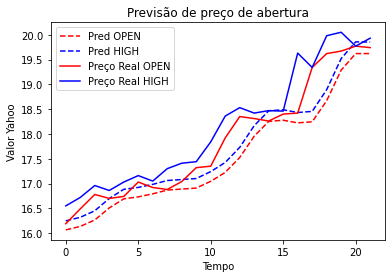

In [13]:
# Criando Grafico;
plt.figure()
plt.plot(pred_test[:,0], color="red", label="Pred OPEN", ls="--")
plt.plot(pred_test[:,1], color="blue", label="Pred HIGH", ls="--")


plt.plot(test.iloc[:, 1:2], color="red", label="Preço Real OPEN" )
plt.plot(test.iloc[:, 2:3], color="blue", label="Preço Real HIGH")

plt.title("Previsão de preço de abertura")
plt.xlabel("Tempo")
plt.ylabel("Valor Yahoo")
plt.legend()
plt.show();